### Faking the ALP spectrum using the XSPEC fakeit function

In [1]:
# importing general packages

import numpy as np
import os, sys
import matplotlib.pyplot as plt

# importing XSPEC

import xspec as xs
xs.Xset.allowPrompting = False #keeps pyxspec from hanging, waiting a response to a prompt
xs.Xset.allowNewAttributes = True

# importing fits 

from astropy.io import fits

In [2]:
# Getting the general files 

E_LLE = np.load('bn121225417_EMeV.npy') # LLE energy bins, [MeV]
energy_binsizes = np.ediff1d(E_LLE) # finding the LLE bin sizes
energy_binsizes = np.append(energy_binsizes, energy_binsizes[-1]) # just to make the array the right size

SED10_norm = np.load('bn121225417SED10_norm.npy') # ALP SED normalized by N, [1e52 ph cm^-2 s^-1 MeV^-1]
N = np.logspace(np.log10(8.4e-8), np.log10(8.4e2), 30) # normalization values, [1e-52 cm^-2]

In [3]:
"""Defining the ALP model
# The SED10 below is the product of Manuel's code and is produced with ALP_spectrum_norm.py. 
# This is going to be the input model with one free parameter, norm1
# (XSPEC assigns normalization as a default fit parameter,
# adding norm1 as it is required to have a manually defined fit parameter. For the future
# analysis, one of the normalizations is always fixed  to 1.) The flux value needs to be given in [ph/s]
"""

SED10 = np.load('bn121225417_SED10.npy') # the output of Manuel's code, N = 1 cm^-2

def ALP(engs, params, flux):
    norm1 = params[0]
    flux[:] = norm1 * SED10[:]*energy_binsizes# the model to be given per bin
    # print(len(flux), len(engs)) # these two have to be the same
        
ALPInfo = ("norm1 cm-2 1.1  1e-12  1e-10 1e10 1e12 0.0001",)
xs.AllModels.addPyMod(ALP, ALPInfo, 'add', spectrumDependent=True)

In [4]:
# Defining the model for XSPEC fakeit. I will fix N[25] as the input normalization (just as a test).

xs.AllData.clear()
xs.AllModels.clear() 
m = xs.Model('ALP') 

# freezing the model parameters 
m.ALP.norm.values = 1
m.ALP.norm.frozen = True
m.ALP.norm1.values = N[25]
m.ALP.norm1.frozen = True

In [5]:
# producing one fake spectrum for a given exposure time (same as the given background in this case, 80 s)
# background file is the corresponding GRB background (Telapse = 80 s, and the response file is that of the 
# GRB)

fs = xs.FakeitSettings(background="bn121225417_LAT-LLE_bkgspectra.bak{1}", response='bn121225417_LAT-LLE_weightedrsp.rsp', exposure=80.0)
sl = 1*[fs] # making only one simulation
xs.AllData.fakeit(1, sl)

In [6]:
# plotting the simulated spectrum (unfolded: https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node114.html)

xs.Plot.device="/xs"
xs.Plot.xAxis="MeV"
xs.Plot.add=True
xs.Plot.background=True
xs.Plot.xLog=True
xs.Plot.yLog=True
xs.Plot.show()
xs.Plot("ufspec") # this is the unfolded spectrum 


User entered plot commands:


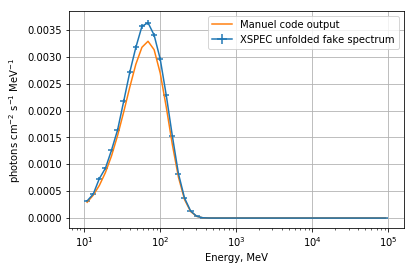

In [7]:
# extracting xs.Plot values for matplotlib for the unfolded simulated spectrum

xerr_uf = np.asarray(xs.Plot.xErr()) # x error in [MeV]
yerr_uf = np.asarray(xs.Plot.yErr()) # y error in [ph/s/MeV/cm^2]
spec_uf = np.asarray(xs.Plot.y()) # unfolded, simulated ALP spectrum, in [ph/s/MeV/cm^2]


plt.errorbar(E_LLE, spec_uf, xerr=xerr_uf, yerr=yerr_uf, label='XSPEC unfolded fake spectrum')
plt.plot(E_LLE, SED10_norm[25,:], label='Manuel code output')
plt.xlabel('Energy, MeV')
plt.ylabel('photons cm$^{-2}$ s$^{-1}$ MeV$^{-1}$ ')
plt.xscale('log')
#plt.yscale('log')
plt.grid()
plt.legend()

In [8]:
# Now, let's plot the folded spectrum. Consider LLE effective area here: 
# https://confluence.slac.stanford.edu/display/SCIGRPS/LLE+2.0

xs.Plot.device="/xs"
xs.Plot.xAxis="MeV"
xs.Plot.add=True
xs.Plot.background=True
xs.Plot.xLog=True
xs.Plot.yLog=True
xs.Plot.show()
xs.Plot("data") # this is the unfolded spectrum 


User entered plot commands:


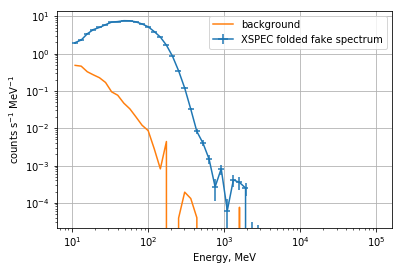

In [9]:
# extracting xs.Plot values for matplotlib for the folded simulated spectrum


xerr_f = np.asarray(xs.Plot.xErr()) # x errors, in [MeV]
yerr_f = np.asarray(xs.Plot.yErr()) # y errors, in [ph/s/MeV]
spec_f = np.asarray(xs.Plot.y()) # simulated folded spectrum, in [ph/s/MeV]
bkg_f = np.asarray(xs.Plot.backgroundVals()) # folded background, in [ph/s/MeV]



plt.errorbar(E_LLE, spec_f, xerr=xerr_f, yerr=yerr_f, label='XSPEC folded fake spectrum') # background subtracted
plt.plot(E_LLE, bkg_f, label = 'background')
plt.xlabel('Energy, MeV')
plt.ylabel('counts s$^{-1}$ MeV$^{-1}$ ')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()

Note that the difference in spectral amplitude between folded and unfolded is a factor of ~2000 for energies below ~400 MeV, which should correspond to the LLE effective area in this energy range?